# Defense Idea implementation

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import tensorflow as tf
import tensorflow_federated as tff
from matplotlib import pyplot as plt

import collections
from tqdm import tqdm
import random
import time
import copy

In [2]:
n_clients = 100
n_test_clients = 300

max_clients = 100


n_train_dataset_epochs = 6
n_test_dataset_epochs = 3
batch_size_train = 20
batch_size_test = 20
shuffle_buffer = 100
prefetch_buffer = 10

n_train_epochs = 20

client_learning_rate = 0.02
server_learning_rate = 1


hidden_units = 256
dropout = 0.1

mal_users_percentage = 0.2
# todo: could also be a list of values
target_value = 3
poisoned_value = 8

open('/home/nikos/msc-thesis/tmp/threshold', 'w').close()
with open('/home/nikos/msc-thesis/tmp/losses', 'w') as f:
    for _ in range(max_clients):
        f.write('0\n')

In [3]:
def batch_format(element):
    # flatten the images
    return collections.OrderedDict(
        x = tf.reshape(element['pixels'], [-1, 28, 28]),
        y = tf.reshape(element['label'], [-1, 1]))

def preprocess(dataset, train):
    if train == True:
        dataset = dataset.repeat(n_train_dataset_epochs)
    else:
        dataset = dataset.repeat(n_test_dataset_epochs)
        
    dataset = dataset.shuffle(shuffle_buffer, seed = 1)
    if train == True:
        dataset = dataset.batch(batch_size_train)
    else: 
        dataset = dataset.batch(batch_size_test)
        
    dataset = dataset.map(batch_format)
    dataset = dataset.prefetch(prefetch_buffer)

    return dataset

In [4]:
emnist_train, emnist_test = tff.simulation.datasets.emnist.load_data()

example_dataset = emnist_train.create_tf_dataset_for_client(
    emnist_train.client_ids[0])

preprocessed_example_dataset = preprocess(example_dataset, True)

In [5]:
def poison_dataset(dataset, target_honest, target_mal):
    def map_fn(element):
        labels = element['y']
        # condition where label equals to target_honest
        condition = tf.equal(labels, target_honest)
        # replace label with target_mal where condition is true
        labels = tf.where(condition, target_mal, labels)
        # replace 'y' in the element dict
        element['y'] = labels
        return element
    # apply the map function to the dataset
    poisoned_dataset = dataset.map(map_fn)
    return poisoned_dataset

In [6]:
def make_federated_data(client_data, client_ids, target_value, poisoned_value, train, mal_users_percentage=0):
    fed_data = []
    
    # Iterate over each client
    for id in client_ids:
        # Preprocess the client's data
        preprocessed_dataset = preprocess(client_data.create_tf_dataset_for_client(id), train)
        
        # Generate a random number. If the number is less than 'mal_users_percentage', this client's data will be poisoned.
        prob = random.random()
        
        # Check if this client's data should be poisoned
        if prob < mal_users_percentage:
            # Poison the data by changing the labels of the target class
            preprocessed_dataset = poison_dataset(preprocessed_dataset, target_value, poisoned_value)
        
        # Add the (possibly poisoned) client data to the federated data
        fed_data.append(preprocessed_dataset)
    
    return fed_data

In [7]:
class SpecificClassRecall(tf.keras.metrics.Metric):
    def __init__(self, class_id, name='specific_class_recall', **kwargs):
        super(SpecificClassRecall, self).__init__(name=name, **kwargs)
        self.class_id = class_id
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        class_id_true = tf.equal(y_true, self.class_id)
        class_id_pred = tf.equal(tf.argmax(y_pred, axis=1), self.class_id)
        self.recall.update_state(class_id_true, class_id_pred, sample_weight)

    def result(self):
        return self.recall.result()

    def reset_states(self):
        self.recall.reset_states()
    
    def get_config(self):
        config = super(SpecificClassRecall, self).get_config()
        config.update({"class_id": self.class_id})
        return config

In [8]:
def create_model():
      return tf.keras.models.Sequential([
      tf.keras.layers.Reshape(input_shape=(28,28,1), target_shape=(28,28,1)),
      tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dropout(dropout),
      tf.keras.layers.Dense(10, activation='softmax')
  ])

In [9]:
def mnist_model():
    keras_model = create_model()
    return tff.learning.models.from_keras_model(
        keras_model,
        input_spec = preprocessed_example_dataset.element_spec,
        loss = tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics = [tf.keras.metrics.SparseCategoricalAccuracy(), SpecificClassRecall(class_id = 3)])     

In [10]:
whimsy_model = mnist_model()
tf_dataset_type = tff.SequenceType(whimsy_model.input_spec)

In [11]:
@tf.function
def client_fake_update(model, dataset, server_weights, client_optimizer):
  """Computes client's loss, appends it to file in order to broadcast to server, does not update gradients"""
  # Initialize the client model with the current server weights.
  client_weights = model.trainable_variables
  default_client_weights = model.trainable_variables

  # Assign the server weights to the client model.
  tf.nest.map_structure(lambda x, y: x.assign(y),
                        client_weights, server_weights)


  # Initialize a variable to accumulate the total loss.
  total_loss = 0.0
  
  # Use the client_optimizer to update the local model.
  for batch in dataset:
    with tf.GradientTape() as tape:
      # Compute a forward pass on the batch of data
      outputs = model.forward_pass(batch)

    # Add the current batch loss to the total loss.
    total_loss += outputs.loss
    
    # Compute the corresponding gradient
    grads = tape.gradient(outputs.loss, client_weights)
    grads_and_vars = zip(grads, client_weights)

    # Apply the gradient using a client optimizer.
    client_optimizer.apply_gradients(grads_and_vars)
    
  tf.print(total_loss, output_stream = "file:///home/nikos/msc-thesis/tmp/losses")
  # tf.print(total_loss)
  
  return default_client_weights

In [12]:
def read_last_n_lines(file_path, n):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    lines = [(line.strip()) for line in lines[-n:]]
    print(lines)    

    return lines

In [13]:
def return_threshold(losses):
    """Function to implement defense, based on losses given"""
    # int(0.4 * len(losses))
    losses.sort()
    return losses[int(0.4 * len(losses))]

In [14]:
@tf.function
def client_update(model, dataset, server_weights, client_optimizer):
  """Performs training (using the server model weights) on the client's dataset."""
  # Initialize the client model with the current server weights.
  client_weights = model.trainable_variables
  # default_client_weights = model.trainable_variables
  default_client_weights = copy.copy(model.trainable_variables)
  
  # Assign the server weights to the client model.
  tf.nest.map_structure(lambda x, y: x.assign(y),
                        client_weights, server_weights)

  losses = read_last_n_lines("/home/nikos/msc-thesis/tmp/losses", n_clients)
  
  threshold = return_threshold(losses)
  
  tf.print(losses, output_stream = "file:///home/nikos/msc-thesis/tmp/threshold")
  threshold = tf.strings.to_number(threshold)

  # Initialize a variable to accumulate the total loss.
  total_loss = 0.0
  
  # Use the client_optimizer to update the local model.
  for batch in dataset:
    with tf.GradientTape() as tape:
      # Compute a forward pass on the batch of data
      outputs = model.forward_pass(batch)

    # Add the current batch loss to the total loss.
    total_loss += outputs.loss
    
    # Compute the corresponding gradient
    grads = tape.gradient(outputs.loss, client_weights)
    grads_and_vars = zip(grads, client_weights)

    # Apply the gradient using a client optimizer.
    client_optimizer.apply_gradients(grads_and_vars)
    
  if total_loss > threshold:
    client_weights = default_client_weights

  return client_weights

In [15]:
@tf.function
def server_update(model, mean_client_weights):
  """Updates the server model weights as the average of the client model weights."""
  model_weights = model.trainable_variables
  # Assign the mean client weights to the server model.
  tf.nest.map_structure(lambda x, y: x.assign(y),
                        model_weights, mean_client_weights)
  return model_weights

In [16]:
@tff.tf_computation
def server_init():
  model = mnist_model()
  return model.trainable_variables

In [17]:
model_weights_type = server_init.type_signature.result

In [18]:
@tff.federated_computation
def initialize_fn():
  return tff.federated_value(server_init(), tff.SERVER)

In [19]:
@tff.tf_computation(tf_dataset_type, model_weights_type)
def client_fake_update_fn(tf_dataset, server_weights):
  model = mnist_model()
  client_optimizer = tf.keras.optimizers.SGD(learning_rate=client_learning_rate)
  return client_fake_update(model, tf_dataset, server_weights, client_optimizer)

In [20]:
@tff.tf_computation(tf_dataset_type, model_weights_type)
def client_update_fn(tf_dataset, server_weights):
  model = mnist_model()
  client_optimizer = tf.keras.optimizers.SGD(learning_rate=client_learning_rate)
  return client_update(model, tf_dataset, server_weights, client_optimizer)

In [21]:
@tff.tf_computation(model_weights_type)
def server_update_fn(mean_client_weights):
  model = mnist_model()
  return server_update(model, mean_client_weights)

In [22]:
federated_server_type = tff.FederatedType(model_weights_type, tff.SERVER)
federated_dataset_type = tff.FederatedType(tf_dataset_type, tff.CLIENTS)

In [23]:
@tff.federated_computation(federated_server_type, federated_dataset_type)
def next_fn(server_weights, federated_dataset):
  # Broadcast the server weights to the clients.
  server_weights_at_client = tff.federated_broadcast(server_weights)

  # fake update
  # Each client computes their updated weights and loss.
  client_weights = tff.federated_map(
      client_fake_update_fn, (federated_dataset, server_weights_at_client))


  mean_client_weights = tff.federated_mean(client_weights)
  server_weights = tff.federated_map(server_update_fn, mean_client_weights)


 # legit update

  # Broadcast the server weights to the clients.
  server_weights_at_client = tff.federated_broadcast(server_weights)

 # Each client computes their updated weights and loss.
  client_weights = tff.federated_map(
      client_update_fn, (federated_dataset, server_weights_at_client))
  
  # The server averages these updates.
  mean_client_weights = tff.federated_mean(client_weights)
  # The server updates its model.
  server_weights = tff.federated_map(server_update_fn, mean_client_weights)

  return server_weights

In [24]:
federated_algorithm = tff.templates.IterativeProcess(
    initialize_fn=initialize_fn,
    next_fn=next_fn
)

In [25]:
emnist_train, emnist_test = tff.simulation.datasets.emnist.load_data()

clients = random.sample(emnist_train.client_ids, 100)

federated_train_data = make_federated_data(emnist_train, clients, 0, 0, train=True)      


In [26]:
central_emnist_test = emnist_test.create_tf_dataset_from_all_clients()
central_emnist_test = preprocess(central_emnist_test, train=False)

In [27]:
def evaluate(server_state, dataset):
  keras_model = create_model()
  keras_model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(), SpecificClassRecall(class_id = 3)]  
  )
  keras_model.set_weights(server_state)
  return keras_model.evaluate(dataset.map(lambda element: (element['x'], element['y'])), verbose=0)


In [28]:
# load the datasets that are going to be used
emnist_train, emnist_test = tff.simulation.datasets.emnist.load_data()

# lists to hold the metrics that we want to compute
accs = []
losses = []
class_recall = []

example_dataset = emnist_train.create_tf_dataset_for_client(
    emnist_train.client_ids[0])

preprocessed_example_dataset = preprocess(example_dataset, True)
 
     
# build the process to have the model's architecture
evaluation_process = tff.learning.algorithms.build_fed_eval(mnist_model)

# initialize the state of the evaluation
sample_test_clients = emnist_test.client_ids[0:n_test_clients]


# federated_test_data = make_federated_data(emnist_test, sample_test_clients, 0, 0, train=False)
federated_test_data = emnist_test.create_tf_dataset_from_all_clients()
federated_test_data = preprocess(federated_test_data, train=False)
# fix the random clients so that they are the same for every model
clients = []

for i in range(n_train_epochs):
    clients.append(random.sample(emnist_train.client_ids, n_clients))

In [29]:
# for mal_users_percentage in [0, 10, 20, 40]:
for mal_users_percentage in [0, 40]:
    server_state = federated_algorithm.initialize()

    eval_acc = []
    eval_loss = []
    eval_recall = []

    # mal_users_percentage = i / 10
    
    emnist_train, emnist_test = tff.simulation.datasets.emnist.load_data()

    print("Model with " + str(mal_users_percentage) + "% mal clients")
    for epoch in tqdm(range(n_train_epochs), position = 0, leave = True):
        # clients = emnist_train.client_ids[0:n_clients]

        federated_train_data = make_federated_data(emnist_train, clients[epoch], target_value, poisoned_value, train=True, mal_users_percentage=(mal_users_percentage / 100))      
        
        # run a next on the training process to train the model
        server_state = federated_algorithm.next(server_state, federated_train_data)           
        # update the model's state and get access to the metrics
        # train_state = result.state
        
        # train_metrics = result.metrics
        # print the training metrics
        
        
        evaluation_output = evaluate(server_state, federated_test_data)

        # get access to the evaluation metrics
        eval_loss.append(evaluation_output[0])
        eval_acc.append(evaluation_output[1])
        eval_recall.append(evaluation_output[2])

    accs.append(eval_acc)
    losses.append(eval_loss)
    class_recall.append(eval_recall)

Model with 0% mal clients


  5%|▌         | 1/20 [00:39<12:39, 39.99s/it]


KeyboardInterrupt: 

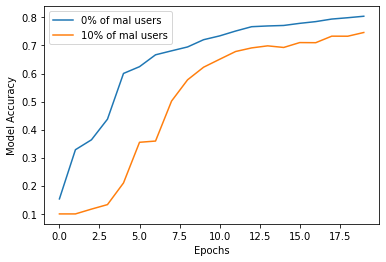

In [ ]:
epochs = [x for x in range(0, n_train_epochs)]
for cnt, model_acc in enumerate(accs):

    plt.plot(epochs, model_acc, label = str(cnt * 10) + "% of mal users")


plt.xlabel("Epochs")
plt.ylabel("Model Accuracy")
plt.legend()
plt.show()

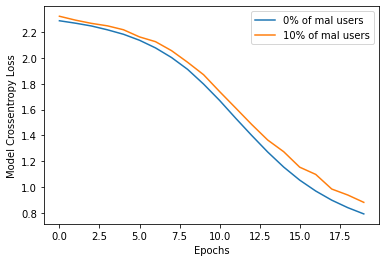

In [ ]:
epochs = [x for x in range(0, n_train_epochs)]
for cnt, model_loss in enumerate(losses):

    plt.plot(epochs, model_loss, label=str(cnt * 10) + "% of mal users")

plt.xlabel("Epochs")
plt.ylabel("Model Crossentropy Loss")
plt.legend()
plt.show()

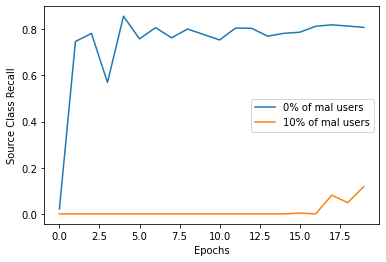

In [ ]:
epochs = [x for x in range(0, n_train_epochs)]
for cnt, model_cross in enumerate(class_recall):

    plt.plot(epochs, model_cross, label=str(cnt * 10) + "% of mal users")

plt.xlabel("Epochs")
plt.ylabel("Source Class Recall")

plt.legend()
plt.show()